In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Common imports
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
from sklearn.cross_validation import train_test_split
from sklearn import svm

In [3]:
# Make plots prettyful
pl.style.use('fivethirtynine')

In [4]:
# Pull in data
demographics = pd.read_excel('../data/DemoData.xlsx')
demographics['tract'] = demographics.ID.astype(str).str.zfill(9)

shp = gp.GeoDataFrame.from_file('../data/merged.json')

shp = shp.merge(demographics, on='tract')

shp.rename(columns={
    'Destination?': 'is_dest',
    'Origin?': 'is_orig',
    'Total Population': 'pop',
    '18 to 24 yrs': '_18_to_24',
    '65 and Above': 'above_65',
    'Median Age': 'age',
    'Non-white': 'nonwhite',
    'English less than "very well"': 'nonenglish',
    'Annaul Individual Income below 10000': 'income_below_10000',
    'Annaul Individual Income below 15000': 'income_below_15000',
    'Median Income': 'income',
    'Below 100 percent of the poverty level': 'below_pov',
    '100 to 149 percent of the poverty level': '_100_149_pov',
    'At or above 150 percent of the poverty level': 'above_150_pov',
    'Citizenship status': 'noncitizen',
    'Place of Birth': 'foreignborn'
}, inplace=True)

lehd = pd.read_csv('../data/merged.csv', dtype={'tract': str})

lehd = lehd.drop([u'Unnamed: 0', u'Both', u'Destination?', u'DollarVanLine', u'Origin?',
       u'average_commute_time', u'average_walk_distance', u'geometry',
       u'number_of_commuters',  u'w_county_tract', u'h_county_tract'], 1)

shp = shp.merge(lehd, on='tract')

# Standardize Value Range
for c in [
        u'average_commute_time', u'average_walk_distance',
        u'number_of_commuters',u'pop',
                       u'_18_to_24',                    u'above_65',
                         u'age',             u'nonwhite',
                  u'nonenglish',    u'income_below_10000',
          u'income_below_15000',                u'income',
                   u'below_pov',           u'_100_149_pov',
               u'above_150_pov',            u'noncitizen',
                 u'foreignborn',
    u'wac_total_jobs',
              u'wac_jobs_lt_29',        u'wac_jobs_30_54',
              u'wac_jobs_gt_55',      u'wac_minc_lt_1250',
          u'wac_minc_1251_3333',      u'wac_minc_gt_3333',
              u'rac_total_jobs',        u'rac_jobs_lt_29',
              u'rac_jobs_30_54',        u'rac_jobs_gt_55',
            u'rac_minc_lt_1250',    u'rac_minc_1251_3333',
            u'rac_minc_gt_3333'
]:
    shp[c] = ((shp[c] - shp[c].mean())/shp[c].std())
    
shp = shp.dropna()

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


In [5]:
data = shp[[
    'average_commute_time', 
    'average_walk_distance',
    'number_of_commuters',
    'pop',
    '_18_to_24',
    'above_65',
    'age',
    'nonwhite',
    'nonenglish',
    'income_below_10000',
    'income_below_15000',
    'income',
    'below_pov',
    '_100_149_pov',
    'above_150_pov',
    'noncitizen',
    'foreignborn',
    'wac_total_jobs',
    'wac_jobs_lt_29',        
    'wac_jobs_30_54',
    'wac_jobs_gt_55', 
    'wac_minc_lt_1250',
    'wac_minc_1251_3333',      
    'wac_minc_gt_3333',
    'rac_total_jobs',
    'rac_jobs_lt_29',
    'rac_jobs_30_54',  
    'rac_jobs_gt_55',
    'rac_minc_lt_1250',    
    'rac_minc_1251_3333',
    'rac_minc_gt_3333'
]].values

is_orig = shp['is_orig'].values
is_dest = shp['is_dest'].values
is_both = shp['Both'].values

In [6]:
np.random.seed(1)

target = is_orig

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=5, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 6}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% origin misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% origin misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% origin misclassified = 0.0659722222222
% nonorigin misclassified = 0.193091231178
Test Set
% origin misclassified = 0.20253164557
% nonorigin misclassified = 0.238888888889


In [7]:
shp['is_orig_pred'] = svc.predict(data)

In [8]:
np.random.seed(1)

target = is_dest

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=7, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 20}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% origin misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% origin misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% origin misclassified = 0.0
% nonorigin misclassified = 0.207591014717
Test Set
% origin misclassified = 0.304347826087
% nonorigin misclassified = 0.262321144674


In [9]:
shp['is_dest_pred'] = svc.predict(data)

In [10]:
shp['orig_plot'] = "None"
shp['orig_plot'][shp['is_orig_pred'] == 1] = "Predicted"
shp['orig_plot'][shp['is_orig'] == 1] = "Actual"

c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


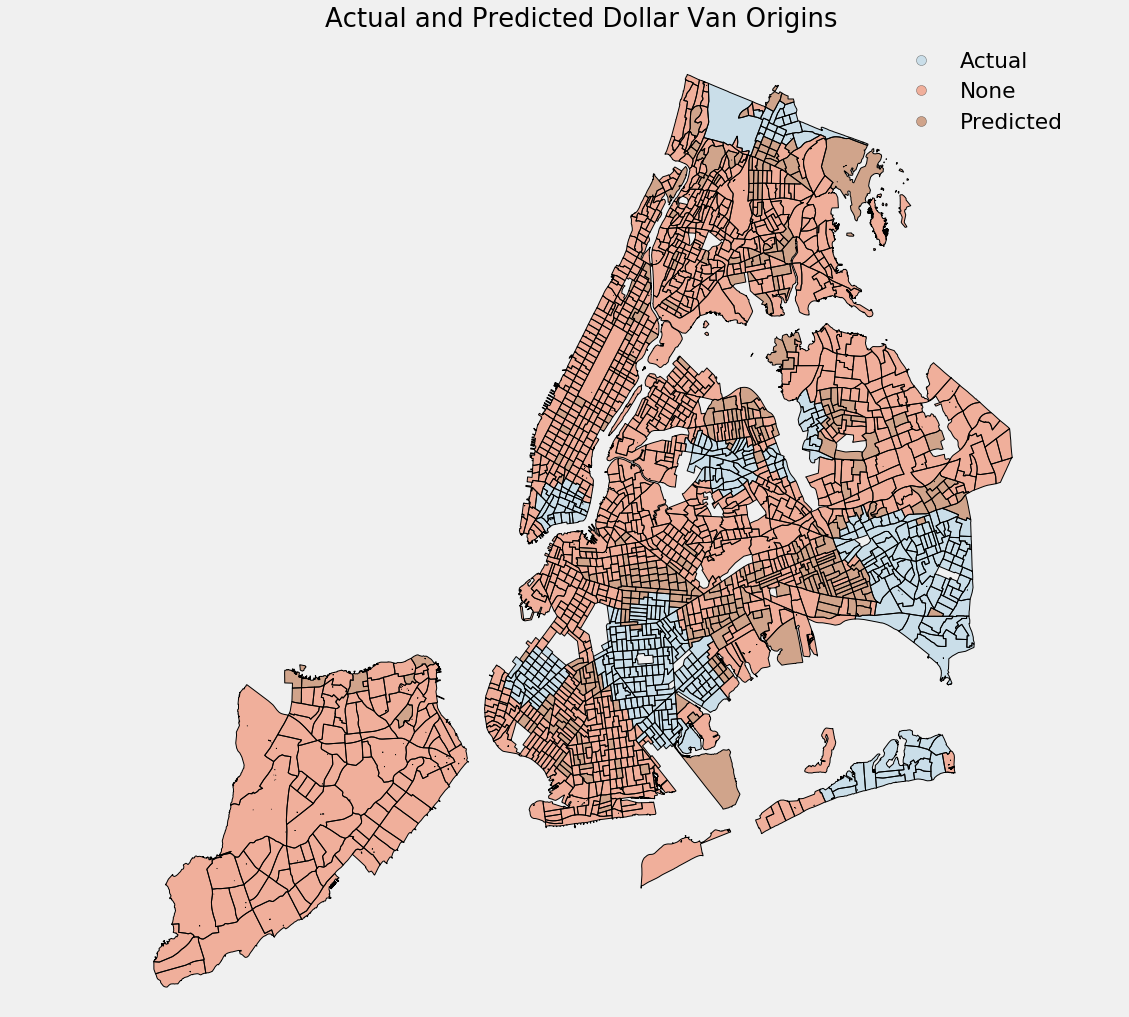

In [11]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp.plot(axes=ax, column='orig_plot', legend=True, categorical=True, colormap='Paired')
ax.set_title('Actual and Predicted Dollar Van Origins')

In [85]:
shp

,Both,is_dest,DollarVanLine,is_orig,average_commute_time,average_walk_distance,geometry,id,number_of_commuters,tract,...,rac_total_jobs,rac_jobs_lt_29,rac_jobs_30_54,rac_jobs_gt_55,rac_minc_lt_1250,rac_minc_1251_3333,rac_minc_gt_3333,is_orig_pred,is_dest_pred,orig_plot
0,0,0,1,1,-1.058380,-0.683937,"POLYGON ((988504.1384277344 198118.3380126953,...",0,0.207354,061000201,...,-0.481200,-0.211516,-0.488903,-0.703167,0.024983,-0.362521,-0.567460,0,0,Actual
1,0,0,1,1,-1.471869,-1.405481,"(POLYGON ((989149.298828125 196328.6047973633,...",1,1.683974,061000202,...,1.263153,0.483150,1.324209,1.824599,1.746437,1.143693,0.807462,1,0,Actual
2,1,1,1,1,-1.676703,-1.549415,"POLYGON ((987978.8082275391 197698.2456054688,...",2,2.794107,061000600,...,2.354364,2.118418,2.402168,2.047477,4.249440,2.688627,0.933989,1,1,Actual
3,0,0,0,0,-1.849505,-1.684508,(POLYGON ((984943.4877929688 194173.7781982422...,3,4.911697,061000700,...,3.331247,5.436415,3.119487,0.590614,0.045416,-0.087608,4.987900,0,0,None
4,1,1,1,1,-1.674524,-1.400408,"POLYGON ((986494.1445922852 197775.8300170898,...",4,2.326977,061000800,...,1.835925,1.208018,1.986044,1.846343,4.372036,1.809679,0.503798,1,1,Actual
5,0,0,0,0,-1.543344,-1.267139,(POLYGON ((984175.4826049805 192471.2318115234...,5,0.744630,061000900,...,-0.392907,-0.133851,-0.320472,-0.839068,-0.971110,-1.311164,0.306417,0,0,None
6,0,0,1,1,-0.806713,-0.383431,"POLYGON ((991128.2537841797 199590.250793457, ...",6,-0.040190,061001001,...,-0.868331,-1.065824,-0.792079,-0.654242,-1.119247,-1.284060,-0.365017,1,0,Actual
7,0,0,1,1,-1.249107,-0.996808,"POLYGON ((990784.524230957 199725.3294067383, ...",7,0.983532,061001002,...,0.449272,0.504723,0.468182,0.237271,1.271377,1.279213,-0.307659,1,0,Actual
8,0,0,1,1,-1.382843,-1.128628,"POLYGON ((989934.2239990234 199730.8380126953,...",8,0.778178,061001200,...,-0.012568,-0.310754,0.147172,-0.072584,-0.215101,-0.459321,0.252432,0,0,Actual
9,0,0,0,0,-1.767690,-1.610795,"POLYGON ((980015.6190185547 196065.4348144531,...",9,2.743785,061001300,...,1.482753,2.256488,1.617477,-0.159561,-0.317264,-0.505785,2.534971,0,0,None


In [90]:
pl.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']